# The Battle of the Neighborhoods

## Finding the most suitable residential neighborhood for families with children in Toronto, Canada

### 1. Scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe

#### read data from website into dataframe

In [8]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df = pd.read_html(url)[0]
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### drop rows from dataframe with a borough that is Not assigned

In [9]:
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace = True)
df.reset_index(drop=True, inplace = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### make sure there's no duplicate Postal Code in the dataframe

In [10]:
print('Number of rows in table:', df.shape[0])
print('Number of unique Postal Codes:', len(df['Postal Code'].unique()))

Number of rows in table: 103
Number of unique Postal Codes: 103


In [11]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

#### make sure all neighborhoods are assigned in the dataframe

In [12]:
df[df['Neighborhood'] == 'Not assigned'].shape

(0, 3)

#### find number of rows in final dataframe

In [13]:
df.shape

(103, 3)

### 2. Get the latitude and the longitude coordinates of each neighborhood

In [ ]:
!wget -q -O Geospatial_Coordinates.csv http://cocl.us/Geospatial_data
print('Data downloaded!')

In [14]:
df_coord = pd.read_csv('Geospatial_Coordinates.csv')
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
df = pd.merge(df,df_coord,on='Postal Code',how='left')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### 3. Explore and cluster the neighborhoods in Toronto

 #### Create dataframe which contains Toronto data for exploring

In [16]:
df_toronto = df

In [17]:
print('The dataframe has {} boroughs and {} neighborhoods in Toronto.'.format(len(df_toronto['Borough'].unique()), len(df_toronto['Neighborhood'].unique())))

The dataframe has 10 boroughs and 99 neighborhoods in Toronto.


#### Use geopy library to get the latitude and longitude values of Toronto

In [18]:
from geopy.geocoders import Nominatim

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top

In [19]:
import folium

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [20]:
# @hidden_cell
CLIENT_ID = 'KGJZQNB0NQ5AN5UEZHZZ02FTDUZWFX2MDVMK0WJMG1Q31E1O' # your Foursquare ID
CLIENT_SECRET = 'ETOWPZOYCTUQYIYDUJE1ZRJSCRUGWAPDRVLADEAV1UE0ORRY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Explore boroughs in Toronto

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get nearby venues of all boroughs in Toronto dataframe

In [23]:
import requests

LIMIT = 100
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [27]:
print(toronto_venues.shape)
toronto_venues.head()

(2134, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


#### Get number of venues for each borough

In [28]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,59,59,59,59,59,59
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


In [29]:
# find the number of unique neighborhood in toronto_venues
print('Number of neighborhood in Toronto venues:', toronto_venues.groupby('Neighborhood').count().shape[0])

# find number of unique venue category in toronto_venues
print('Number of unique venue category in Toronto venues:', toronto_venues['Venue Category'].nunique())

Number of neighborhood in Toronto venues: 94
Number of unique venue category in Toronto venues: 271


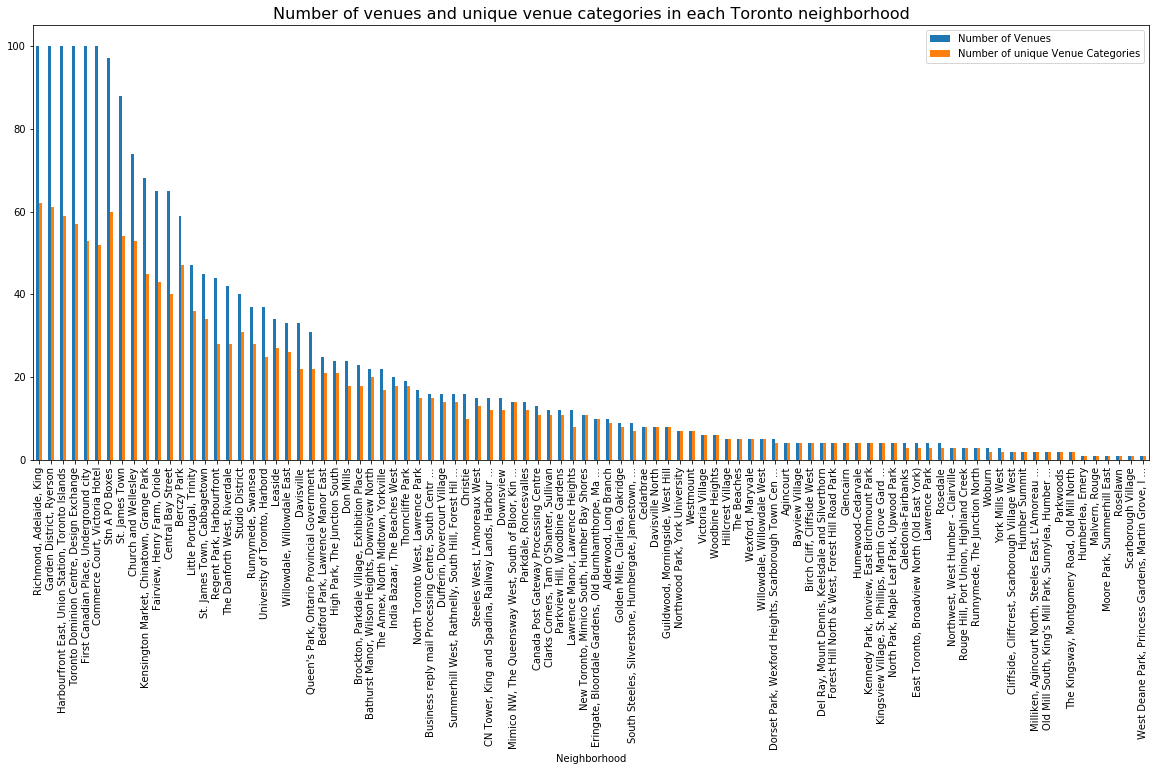

In [30]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

toronto_venues_g = toronto_venues.groupby('Neighborhood').agg(num_venues=pd.NamedAgg(column='Venue Category', aggfunc='count'), \
                                                                num_cat=pd.NamedAgg(column='Venue Category', aggfunc='nunique')).sort_values(by=['num_venues', 'num_cat'], ascending=False)
toronto_venues_g.index = [s[:50] if len(s) <= 50 else s[:50]+' ...' for s in toronto_venues_g.index ]

toronto_venues_g.plot(kind='bar', figsize=(20, 8))

#plt.xlabel('Number of venues') # add to x-label to the plot
plt.xlabel('Neighborhood')
plt.title('Number of venues and unique venue categories in each Toronto neighborhood', fontsize=16) # add title to the plot
plt.legend(['Number of Venues','Number of unique Venue Categories'])

plt.show()

In [31]:
# remove neighborhoods with less than 4 veune categories
toronto_venues_g2 = toronto_venues.groupby('Neighborhood').count()
toronto_venues_g2 = toronto_venues_g2[toronto_venues_g2['Venue Category'] > 3]
toronto_venues_2 = toronto_venues[toronto_venues['Neighborhood'].isin(toronto_venues_g2.index.values)]
toronto_venues_2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
5,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
6,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection


#### Analyze each neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_2[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.rename(columns={'Neighborhood': 'Neighborhood_venue'}, inplace=True)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Get the mean of the frequency of occurrence of each category for each neighborhood

In [33]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood_venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [34]:
toronto_grouped.shape

(77, 266)

####  Find and display the top 10 venues for each neighborhood

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Latin American Restaurant,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Athletics & Sports,Pub,Sandwich Place,Dance Studio,Skating Rink,Pharmacy,Gym,Gay Bar
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Fried Chicken Joint,Shopping Mall,Bridal Shop,Deli / Bodega,Sandwich Place,Middle Eastern Restaurant,Mobile Phone Shop
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Italian Restaurant,Sandwich Place,Pharmacy,Thai Restaurant,Butcher,Indian Restaurant,Sushi Restaurant,Café


#### Cluster the neighborhoods

In [37]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=7).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 0, 3, 4, 4, 4, 4, 4, 4])

C:\Users\awsc\programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


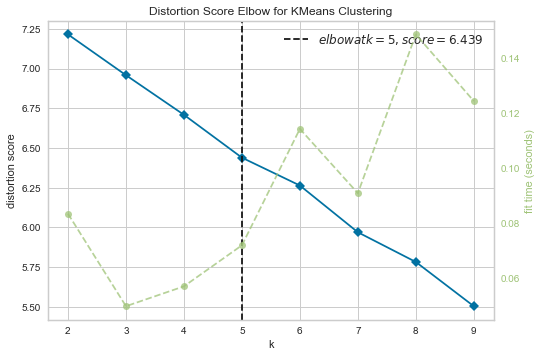

C:\Users\awsc\programs\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C6236CF88>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [38]:
#!pip install yellowbrick
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

X = toronto_grouped_clustering

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=7), X, k=(2,10))

In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = neighborhoods_venues_sorted.join(df_toronto.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
0,4,Agincourt,Skating Rink,Lounge,Latin American Restaurant,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,M1S,Scarborough,43.794200,-79.262029
1,3,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Athletics & Sports,Pub,Sandwich Place,Dance Studio,Skating Rink,Pharmacy,Gym,Gay Bar,M8W,Etobicoke,43.602414,-79.543484
2,0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Fried Chicken Joint,Shopping Mall,Bridal Shop,Deli / Bodega,Sandwich Place,Middle Eastern Restaurant,Mobile Phone Shop,M3H,North York,43.754328,-79.442259
3,3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M2K,North York,43.786947,-79.385975
4,4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Italian Restaurant,Sandwich Place,Pharmacy,Thai Restaurant,Butcher,Indian Restaurant,Sushi Restaurant,Café,M5M,North York,43.733283,-79.419750


In [40]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['red', 'blue', 'green', 'purple', 'orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [41]:
df_schools = pd.read_csv('toronto_top_schools_location.csv')
df_schools

,Name,Latitude,Longitude
0,Avondale Elementary Alternative School,43.759209,-79.401005
1,St. Michael’s Choir School,43.655597,-79.377687
2,St. Sebastian Catholic School,43.662470,-79.439850
3,Cardinal Carter Academy For The Arts,43.764068,-79.409718
4,Ursula Franklin Academy,43.657515,-79.474088
5,Lawrence Park Collegiate Institute,43.721974,-79.410811
6,North Toronto Collegiate Institute,43.709256,-79.396636
7,Leaside High School,43.711303,-79.373046
8,Malvern Collegiate Institute,43.682644,-79.292959
9,Forest Hill Collegiate Institute,43.703098,-79.421162


In [42]:
# instantiate a feature group for the schools in the dataframe
schools = folium.map.FeatureGroup()

#df_schools = read_csv('toronto_top_schools_location.csv')

# loop through the schools and add each to the schools feature group
for lat, lng, in zip(df_schools.Latitude, df_schools.Longitude):
    schools.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(df_schools.Latitude)
longitudes = list(df_schools.Longitude)
labels = list(df_schools.Name)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_clusters)    
    
# add schools to map
map_clusters.add_child(schools)

#### Examine the clusters

##### Cluster 0

In [43]:
c0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]
c0

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
2,0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pharmacy,Fried Chicken Joint,Shopping Mall,Bridal Shop,Deli / Bodega,Sandwich Place,Middle Eastern Restaurant,Mobile Phone Shop,M3H,North York,43.754328,-79.442259
11,0,Canada Post Gateway Processing Centre,Hotel,Coffee Shop,Gas Station,American Restaurant,Fried Chicken Joint,Sandwich Place,Burrito Place,Middle Eastern Restaurant,Intersection,Mediterranean Restaurant,M7R,Mississauga,43.636966,-79.615819
13,0,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Japanese Restaurant,Sandwich Place,Burger Joint,Bubble Tea Shop,Bar,Department Store,Thai Restaurant,M5G,Downtown Toronto,43.657952,-79.387383
15,0,Church and Wellesley,Coffee Shop,Japanese Restaurant,Restaurant,Gay Bar,Sushi Restaurant,Yoga Studio,Hotel,Pizza Place,Pub,Men's Store,M4Y,Downtown Toronto,43.665860,-79.383160
17,0,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Hotel,Gym,American Restaurant,Deli / Bodega,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,M5L,Downtown Toronto,43.648198,-79.379817
21,0,Don Mills,Gym,Coffee Shop,Restaurant,Japanese Restaurant,Beer Store,Italian Restaurant,Café,Sandwich Place,Caribbean Restaurant,Dim Sum Restaurant,M3B,North York,43.745906,-79.352188
21,0,Don Mills,Gym,Coffee Shop,Restaurant,Japanese Restaurant,Beer Store,Italian Restaurant,Café,Sandwich Place,Caribbean Restaurant,Dim Sum Restaurant,M3C,North York,43.725900,-79.340923
27,0,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Restaurant,Food Court,Juice Bar,Bank,Bakery,Tea Room,M2J,North York,43.778517,-79.346556
28,0,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Gym,Asian Restaurant,Steakhouse,Deli / Bodega,American Restaurant,M5X,Downtown Toronto,43.648429,-79.382280
30,0,"Garden District, Ryerson",Clothing Store,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Café,Italian Restaurant,Bubble Tea Shop,Ramen Restaurant,Theater,M5B,Downtown Toronto,43.657162,-79.378937


In [44]:
c0.shape

(25, 16)

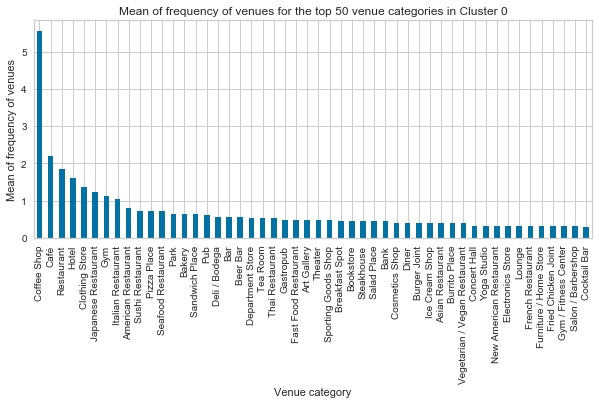

In [45]:
arr_c0 = c0['Neighborhood'].values
df_c0 = toronto_venues_2[toronto_venues_2['Neighborhood'].isin(arr_c0)][['Neighborhood','Venue Category']].set_index('Neighborhood')
df_c0_onehot = pd.get_dummies(df_c0[['Venue Category']], prefix="", prefix_sep="")
df_c0_onehot_g = df_c0_onehot.sum().sort_values(ascending=False)[:50]/c0['Neighborhood'].shape[0]

df_c0_onehot_g.plot(kind='bar', legend=None, figsize=(10, 4))
plt.xlabel('Venue category')
plt.ylabel('Mean of frequency of venues')
plt.title('Mean of frequency of venues for the top 50 venue categories in Cluster 0')
#plt.grid(b=None)
plt.show()

##### Cluster 1

In [47]:
c1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]
c1

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
10,1,Caledonia-Fairbanks,Park,Women's Store,Pool,Yoga Studio,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,M6E,York,43.689026,-79.453512
25,1,"East Toronto, Broadview North (Old East York)",Park,Metro Station,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Yoga Studio,M4J,East York,43.685347,-79.338106
43,1,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Distribution Center,M4N,Central Toronto,43.728020,-79.388790
56,1,Rosedale,Park,Playground,Trail,Yoga Studio,Diner,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,M4W,Downtown Toronto,43.679563,-79.377529


In [48]:
c1.shape

(4, 16)

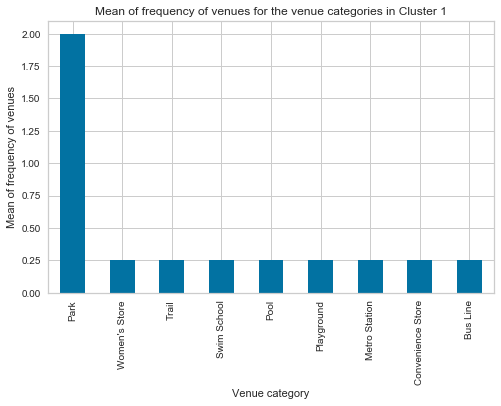

In [49]:
arr_c1 = c1['Neighborhood'].values
df_c1 = toronto_venues_2[toronto_venues_2['Neighborhood'].isin(arr_c1)][['Neighborhood','Venue Category']].set_index('Neighborhood')
df_c1_onehot = pd.get_dummies(df_c1[['Venue Category']], prefix="", prefix_sep="")
df_c1_onehot_g = df_c1_onehot.sum().sort_values(ascending=False)/c1['Neighborhood'].shape[0]

df_c1_onehot_g.plot(kind='bar', legend=None, figsize=(8, 5))
plt.xlabel('Venue category')
plt.ylabel('Mean of frequency of venues')
plt.title('Mean of frequency of venues for the venue categories in Cluster 1')
#plt.grid(b=None)
plt.show()

##### Cluster 2

In [50]:
c2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]
c2

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
48,2,"North Park, Maple Leaf Park, Upwood Park",Basketball Court,Park,Bakery,Construction & Landscaping,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,M6L,North York,43.713756,-79.490074


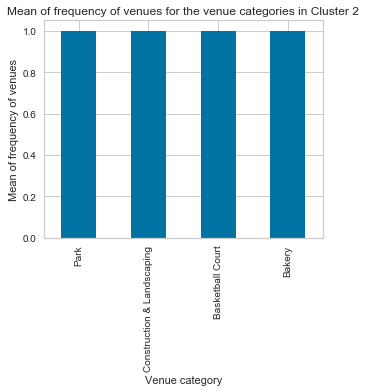

In [51]:
arr_c2 = c2['Neighborhood'].values
df_c2 = toronto_venues_2[toronto_venues_2['Neighborhood'].isin(arr_c2)][['Neighborhood','Venue Category']].set_index('Neighborhood')
df_c2_onehot = pd.get_dummies(df_c2[['Venue Category']], prefix="", prefix_sep="")
df_c2_onehot_g = df_c2_onehot.sum().sort_values(ascending=False)/c2['Neighborhood'].shape[0]

df_c2_onehot_g.plot(kind='bar', legend=None, figsize=(5, 4))
plt.xlabel('Venue category')
plt.ylabel('Mean of frequency of venues')
plt.title('Mean of frequency of venues for the venue categories in Cluster 2')
#plt.grid(b=None)
plt.show()

##### Cluster 3

In [52]:
c3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]
c3

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
1,3,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Athletics & Sports,Pub,Sandwich Place,Dance Studio,Skating Rink,Pharmacy,Gym,Gay Bar,M8W,Etobicoke,43.602414,-79.543484
3,3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M2K,North York,43.786947,-79.385975
16,3,"Clarks Corners, Tam O'Shanter, Sullivan",Pizza Place,Pharmacy,Gas Station,Fried Chicken Joint,Thai Restaurant,Convenience Store,Chinese Restaurant,Italian Restaurant,Noodle House,Fast Food Restaurant,M1T,Scarborough,43.781638,-79.304302
20,3,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",Convenience Store,Sandwich Place,Bar,Discount Store,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Yoga Studio,M6M,York,43.691116,-79.476013
41,3,"Kingsview Village, St. Phillips, Martin Grove ...",Sandwich Place,Bus Line,Mobile Phone Shop,Pizza Place,Dim Sum Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,M9R,Etobicoke,43.688905,-79.554724
52,3,"Parkview Hill, Woodbine Gardens",Pizza Place,Gym / Fitness Center,Athletics & Sports,Café,Breakfast Spot,Pet Store,Fast Food Restaurant,Bank,Intersection,Pharmacy,M4B,East York,43.706397,-79.309937
58,3,"South Steeles, Silverstone, Humbergate, Jamest...",Pizza Place,Grocery Store,Sandwich Place,Pharmacy,Beer Store,Fast Food Restaurant,Fried Chicken Joint,Colombian Restaurant,Dance Studio,College Cafeteria,M9V,Etobicoke,43.739416,-79.588437
61,3,"Steeles West, L'Amoreaux West",Fast Food Restaurant,Chinese Restaurant,Breakfast Spot,Bank,Burger Joint,Thrift / Vintage Store,Discount Store,Grocery Store,Coffee Shop,Pizza Place,M1W,Scarborough,43.799525,-79.318389
72,3,Westmount,Pizza Place,Discount Store,Chinese Restaurant,Intersection,Middle Eastern Restaurant,Coffee Shop,Sandwich Place,Dog Run,Distribution Center,Diner,M9P,Etobicoke,43.696319,-79.532242
75,3,"Willowdale, Willowdale West",Pharmacy,Coffee Shop,Bank,Pizza Place,Grocery Store,College Gym,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,M2R,North York,43.782736,-79.442259


In [53]:
c3.shape

(10, 16)

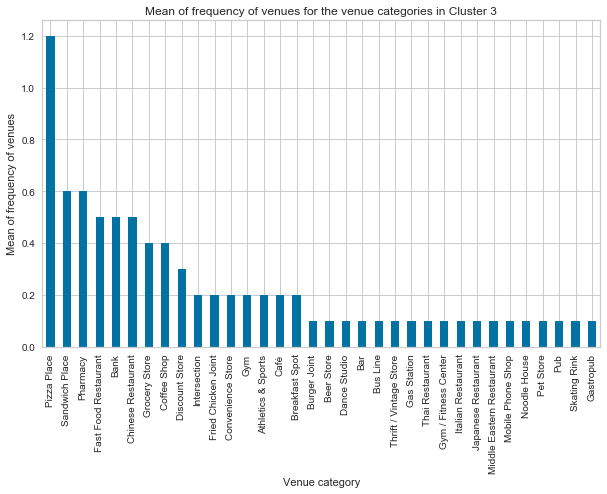

In [54]:
arr_c3 = c3['Neighborhood'].values
df_c3 = toronto_venues_2[toronto_venues_2['Neighborhood'].isin(arr_c3)][['Neighborhood','Venue Category']].set_index('Neighborhood')
df_c3_onehot = pd.get_dummies(df_c3[['Venue Category']], prefix="", prefix_sep="")
df_c3_onehot_g = df_c3_onehot.sum().sort_values(ascending=False)/c3['Neighborhood'].shape[0]

df_c3_onehot_g.plot(kind='bar', legend=None, figsize=(10, 6))
plt.xlabel('Venue category')
plt.ylabel('Mean of frequency of venues')
plt.title('Mean of frequency of venues for the venue categories in Cluster 3')
#plt.grid(b=None)
plt.show()

##### Cluster 4

In [55]:
c4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]
c4

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
0,4,Agincourt,Skating Rink,Lounge,Latin American Restaurant,Breakfast Spot,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,M1S,Scarborough,43.794200,-79.262029
4,4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Italian Restaurant,Sandwich Place,Pharmacy,Thai Restaurant,Butcher,Indian Restaurant,Sushi Restaurant,Café,M5M,North York,43.733283,-79.419750
5,4,Berczy Park,Coffee Shop,Bakery,Pharmacy,Restaurant,Café,Cheese Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Farmers Market,M5E,Downtown Toronto,43.644771,-79.373306
6,4,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M1N,Scarborough,43.692657,-79.264848
7,4,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Convenience Store,Bar,Intersection,Bakery,Restaurant,Stadium,M6K,West Toronto,43.636847,-79.428191
8,4,"Business reply mail Processing Centre, South C...",Light Rail Station,Gym / Fitness Center,Auto Workshop,Pizza Place,Comic Shop,Restaurant,Burrito Place,Brewery,Skate Park,Spa,M7Y,East Toronto,43.662744,-79.321558
9,4,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Plane,Airport Terminal,Boat or Ferry,Sculpture Garden,Rental Car Location,Harbor / Marina,Boutique,Airport,M5V,Downtown Toronto,43.628947,-79.394420
12,4,Cedarbrae,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bakery,Bank,Athletics & Sports,Thai Restaurant,Caribbean Restaurant,Deli / Bodega,Department Store,M1H,Scarborough,43.773136,-79.239476
14,4,Christie,Grocery Store,Café,Park,Nightclub,Italian Restaurant,Candy Store,Restaurant,Diner,Baby Store,Coffee Shop,M6G,Downtown Toronto,43.669542,-79.422564
18,4,Davisville,Dessert Shop,Sandwich Place,Pizza Place,Coffee Shop,Gym,Italian Restaurant,Café,Sushi Restaurant,Pharmacy,Thai Restaurant,M4S,Central Toronto,43.704324,-79.388790


In [56]:
c4.shape

(41, 16)

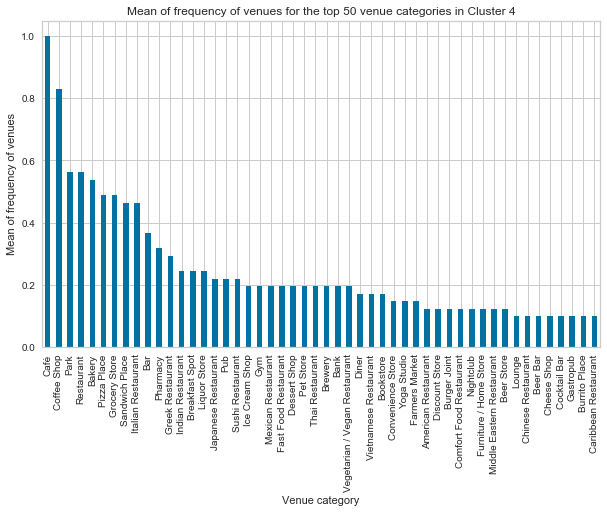

In [57]:
arr_c4 = c4['Neighborhood'].values
df_c4 = toronto_venues_2[toronto_venues_2['Neighborhood'].isin(arr_c4)][['Neighborhood','Venue Category']].set_index('Neighborhood')
df_c4_onehot = pd.get_dummies(df_c4[['Venue Category']], prefix="", prefix_sep="")
df_c4_onehot_g = df_c4_onehot.sum().sort_values(ascending=False)[:50]/c4['Neighborhood'].shape[0]

df_c4_onehot_g.plot(kind='bar', legend=None, figsize=(10, 6))
plt.xlabel('Venue category')
plt.ylabel('Mean of frequency of venues')
plt.title('Mean of frequency of venues for the top 50 venue categories in Cluster 4')
#plt.grid(b=None)
plt.show()